In [1]:
%pip install sympy
%pip install tqdm
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


<h1>->Optimización de silueta NACA 0015 </h>

<h2>Importación de bibliotecas</h2>

In [2]:
import numpy as np                          #manejo de arrays y matrices, y proporciona funciones matemáticas avanzadas.
import psutil                               #Importa el módulo psutil. Este módulo se usa para obtener información sobre procesos y utilización del sistema (como memoria, CPU).
import math                                 #Importa el módulo math, que proporciona funciones matemáticas básicas y constantes.
from scipy.optimize import dual_annealing   #Importa la función 'dual_annealing' del submódulo optimize de SciPy. Esta función se utiliza para la optimización global.
import sympy                                #matemáticas simbólicas.
import subprocess                           #generar nuevos procesos, conectar a sus tuberías de entrada/salida/error, y obtener sus códigos de retorno.
import glob                                 #buscar archivos en un directorio que coincidan con un patrón especificado.
from queue import PriorityQueue             #proporciona la funcionalidad de una cola de prioridad.
import re as regex                          #soporte para trabajar con expresiones regulares.
import os                                   #proporciona una forma de usar funcionalidades dependientes del sistema operativo, como leer o escribir en el sistema de archivos.
import matplotlib.pyplot as plt             #visualizaciones estáticas, animadas e interactivas en Python.
from scipy.optimize import fsolve           #encontrar las raíces de una función.
from tqdm import tqdm 
import pandas as pd

<h2>1. Ingreso de coordenadas [x,y] para extrados e intrados</h2>

Nota: Se elimino el valor de conexión entre extrados e intrados [0,0] 

-> Extrados(+)

In [3]:
xe=[1,0.9,0.5,0.2,0.075,0.0125]
ye=[0.00158,0.0181,0.06617,0.07171,0.0525,0.02367]
print(" xe","\t"," ye")
matrix_length = len(xe)
for i in range(matrix_length):
    print(f"{xe[i]:.3f}","\t",f"{ye[i]:.3f}") 

 xe 	  ye
1.000 	 0.002
0.900 	 0.018
0.500 	 0.066
0.200 	 0.072
0.075 	 0.052
0.013 	 0.024


-> Intrados(-)

In [4]:
xi=[0.0125,0.1,0.25,0.5,0.8,1]
yi=[-0.02367,-0.05853,-0.07427,-0.06617,-0.03279,-0.00158]
print(" xi","\t"," yi")
matrix_length = len(xi)
for i in range(matrix_length):
    print(f"{xi[i]:.3f}","\t",f"{yi[i]:.3f}") 

 xi 	  yi
0.013 	 -0.024
0.100 	 -0.059
0.250 	 -0.074
0.500 	 -0.066
0.800 	 -0.033
1.000 	 -0.002


<h2>2. Sistema de ecuaciones para encontrar los coeficientes "a" de las funciones de extrados e intrados</h2>

->Calculo de coeficientes de la función de extrados

In [5]:
A = np.array([[pow(xe[j], i + 0.5) for i in range(0, 6)] for j in range(0, 6)])
b = np.array(ye)
sol_e = np.linalg.solve(A, b)
print(sol_e)


[ 0.21629922 -0.3764023   0.76892803 -1.7756928   1.87827312 -0.70982528]


->Calculo de coeficientes de la función de intrados

In [6]:
A = np.array([[pow(xi[j], i + 0.5) for i in range(0, 6)] for j in range(0, 6)])
b = np.array(yi)
sol_i = np.linalg.solve(A, b)
print(sol_i)

[-0.21610423  0.35882561 -0.60509889  1.31885458 -1.39695687  0.5388998 ]


<h3>Nota: Aquí se verifican los resultados posteriores para y"emáx, y"imin, x_emax & x_imin

-> Calcular X_emax 


In [7]:
xee = sympy.symbols('xee')
fe = sum(sol_e[i]*xee**(i + 0.5) for i in range(0, 6))

dy = sympy.diff(fe, xee)

sol = sympy.solve(dy, xee)

def is_sol(xee):
    if sympy.im(xee) != 0:
        return False
    if xee < 0 or xee > 1:
        return False
    return True

x_eemax =float([xee for xee in sol if is_sol(xee)][0])
print("x_eemax=",x_eemax)

x_eemax= 0.30878446857324193


-> Calcular X_imax 

In [8]:
xii = sympy.symbols('xii')
fi = sum(sol_i[i]*xii**(i + 0.5) for i in range(0, 6))

dy = sympy.diff(fi, xii)

sol = sympy.solve(dy, xii)

def is_sol(xii):
    if sympy.im(xii) != 0:
        return False
    if xii < 0 or xii > 1:
        return False
    return True

x_imin = float([xii for xii in sol if is_sol(xii)][0])
print("x_imin=",x_imin)

x_imin= 0.30569537525167684


<h2>3. Parametrización del perfil original

-> Variables simbolicas, no son numeros. Se crean para desarrollar el sistema de ecuaciones

In [9]:
y_emax, y_imax, alpha, beta, y_bs, deltay_bs, x_emax, x_imax, dy_emax, dy_imax, r_bae,r_bai=sympy.symbols("y_emax, y_imax, alpha, beta, y_bs, deltay_bs, x_emax,x_imax, dy_emax, dy_imax, r_bae,r_bai")

->Los valores de ae & ai se vuelven simbolicos para emplearlo en el sistema (Iteradores)

In [10]:
ae=sympy.symbols("ae:6")
ai=sympy.symbols("ai:6")
k=sympy.symbols("k",integer=True)

-> Ecuaciones a resolver

In [11]:
eq1=sympy.sqrt(2*r_bai)+ai[0]
eq12=sympy.sqrt(2*r_bae)-ae[0]
#extrados
eq2 =sum([ae[k-1]*pow(x_emax, k-0.5) for k in range(1, 7)])-y_emax
eq3=sum([(k-0.5)*ae[k-1]*pow(x_emax, k-1.5) for k in range(1, 7)])
eq4=sum([(k-1.5)*(k-0.5)*ae[k-1]*pow(x_emax, k-2.5) for k in range(1, 7)])-dy_emax
eq5=sum([ae[k-1] for k in range(1, 7)])-y_bs+0.5*deltay_bs    #ybs+deltaybs esto tiene que ser 0 porque se encuentra la punta cerrada y conectada en el eje x
eq6=sum([(k-0.5)*ae[k-1] for k in range(1, 7)])-sympy.tan((2*alpha-beta)/2)
#intrados 
eq7=sum([ai[k-1]*pow(x_imax, k-0.5) for k in range(1, 7)])-y_imax
eq8=sum([(k-0.5)*ai[k-1]*pow(x_imax, k-1.5) for k in range(1, 7)])
eq9=sum([(k-1.5)*(k-0.5)*ai[k-1]*pow(x_imax, k-2.5) for k in range(1, 7)])-dy_imax
eq10=sum([ai[k-1] for k in range(1, 7)])-y_bs-0.5*deltay_bs   #ybs+deltaybs esto tiene que ser 0 porque se encuentra la punta cerrada y conectada en el eje x
eq11=sum([(k-0.5)*ai[k-1] for k in range(1, 7)])-sympy.tan((2*alpha+beta)/2)
#Fueron igualadas a 0 para crear el sistema de solución con ayuda de sympy

-> Impresión de las ecuaciones 

In [12]:
display(eq1)
display(eq2)
display(eq3)
display(eq4)
display(eq5)
display(eq6)
display(eq7)
display(eq8)
display(eq9)
display(eq10)
display(eq11)
display(eq12)

ai0 + sqrt(2)*sqrt(r_bai)

ae0*x_emax**0.5 + ae1*x_emax**1.5 + ae2*x_emax**2.5 + ae3*x_emax**3.5 + ae4*x_emax**4.5 + ae5*x_emax**5.5 - y_emax

0.5*ae0/x_emax**0.5 + 1.5*ae1*x_emax**0.5 + 2.5*ae2*x_emax**1.5 + 3.5*ae3*x_emax**2.5 + 4.5*ae4*x_emax**3.5 + 5.5*ae5*x_emax**4.5

-0.25*ae0/x_emax**1.5 + 0.75*ae1/x_emax**0.5 + 3.75*ae2*x_emax**0.5 + 8.75*ae3*x_emax**1.5 + 15.75*ae4*x_emax**2.5 + 24.75*ae5*x_emax**3.5 - dy_emax

ae0 + ae1 + ae2 + ae3 + ae4 + ae5 + 0.5*deltay_bs - y_bs

0.5*ae0 + 1.5*ae1 + 2.5*ae2 + 3.5*ae3 + 4.5*ae4 + 5.5*ae5 - tan(alpha - beta/2)

ai0*x_imax**0.5 + ai1*x_imax**1.5 + ai2*x_imax**2.5 + ai3*x_imax**3.5 + ai4*x_imax**4.5 + ai5*x_imax**5.5 - y_imax

0.5*ai0/x_imax**0.5 + 1.5*ai1*x_imax**0.5 + 2.5*ai2*x_imax**1.5 + 3.5*ai3*x_imax**2.5 + 4.5*ai4*x_imax**3.5 + 5.5*ai5*x_imax**4.5

-0.25*ai0/x_imax**1.5 + 0.75*ai1/x_imax**0.5 + 3.75*ai2*x_imax**0.5 + 8.75*ai3*x_imax**1.5 + 15.75*ai4*x_imax**2.5 + 24.75*ai5*x_imax**3.5 - dy_imax

ai0 + ai1 + ai2 + ai3 + ai4 + ai5 - 0.5*deltay_bs - y_bs

0.5*ai0 + 1.5*ai1 + 2.5*ai2 + 3.5*ai3 + 4.5*ai4 + 5.5*ai5 - tan(alpha + beta/2)

-ae0 + sqrt(2)*sqrt(r_bae)

<h3>->Simplificación con suposición

In [13]:
eq=[ eq1, eq2,  eq4 , eq6, eq7, eq9, eq11, eq12] #Se crea un grupo para todas las ecuaciones, NOTA SE ELIMINA 3,5,8, 10 PORQUE VALEN 0!!!!
for i in range(len(eq)):
    for j in range(len(sol_e)):
        eq[i]=eq[i].subs(ae[j],sol_e[j])
    for j in range(len(sol_i)):
        eq[i]=eq[i].subs(ai[j],sol_i[j])
    eq[i]=eq[i].subs({ 'x_emax':x_eemax, 'x_imax':x_imin, 'deltay_bs':0, 'y_bs':0 }) #con derivadas se determina rapidamente estos valores para ayudar al solver

for e in eq:
    display(e) #todo esta igualado a cero

sqrt(2)*sqrt(r_bai) - 0.216104231480138

0.0756791196649323 - y_emax

-dy_emax - 0.606891441543721

-tan(alpha - beta/2) - 0.200868532006322

-y_imax - 0.0752183863988627

0.576126485925762 - dy_imax

0.211073092778768 - tan(alpha + beta/2)

sqrt(2)*sqrt(r_bae) - 0.216299222323552

<h3>->Solver </h3>

In [14]:
def sistema_ecuaciones(x):
    eqv = list(map(lambda eq: float(eq.subs({  #programación funcional 
       'r_bai': x[0],
       'r_bae': x[7],
       'y_emax': x[1],
       'dy_emax': x[2],
       'alpha': x[3],
       'beta':x[5],
       'dy_imax': x[6],
       'y_imax':x[4]
    })),eq))

    return eqv

-> Se crean variables cero para permitir a Python resolver de forma lineal, con esto, se logra emplear el solver de "fsolve"

In [15]:
# Valores iniciales para las variables
x0 = np.zeros(len(eq))

# Resolver el sistema de ecuaciones
solucion = fsolve(sistema_ecuaciones, x0)

# Mostrar las soluciones aproximadas
print("Soluciones aproximadas:")
for i in solucion:
  print("%.4f" % i)

Soluciones aproximadas:
0.0234
0.0757
-0.6069
0.0049
-0.0752
0.4063
0.5761
0.0234


In [16]:
sol=np.array([*solucion]) #sprad operador de esparcir 


<h2>4. Calculo de los parametros de los perfiles variados 

In [17]:
def evalue_combi(i,j,k,re,ra,b,ye,yi):
    i, j, k, re, ra, b,ye,yi= i / 100, j/100, k/100, re/100, ra/100, b/100, ye/100,  yi/100
    sol[2]=solucion[2]*i#   'dy_emax': i
    sol[3]=solucion[3]*j#   'alpha': j
    sol[6]=solucion[6]*k#   'dy_imin': k
    sol[7]=solucion[7]*re#  'r_bae':re
    sol[0]=solucion[0]*ra#  'r_bai':ra
    sol[5]=solucion[5]*b#   'beta':b
    sol[1]=solucion[1]*ye#    'y_emax': x[1]:ye
    sol[4]=solucion[4]*yi#'y_imax':x[4]:yi
    eq1=[1.0,0,0,0,0,0]
    #extrados
    eq2 =[pow(x_eemax, k-0.5) for k in range(1, 7)]
    eq3=[(k-0.5)*pow(x_eemax, k-1.5) for k in range(1, 7)]
    eq4=[(k-1.5)*(k-0.5)*pow(x_eemax, k-2.5) for k in range(1, 7)]
    eq5=[1 for k in range(1, 7)]  #ybs+deltaybs esto tiene que ser 0 porque se encuentra la punta cerrada y conectada en el eje x
    eq6=[(k-0.5) for k in range(1, 7)]
    #intrados 
    eq7=[pow(x_imin, k-0.5) for k in range(1, 7)]
    eq8=[(k-0.5)*pow(x_imin, k-1.5) for k in range(1, 7)]
    eq9=[(k-1.5)*(k-0.5)*pow(x_imin, k-2.5) for k in range(1, 7)]
    eq10=[1 for k in range(1, 7)] #ybs+deltaybs esto tiene que ser 0 porque se encuentra la punta cerrada y conectada en el eje x
    eq11=[(k-0.5) for k in range(1, 7)]
    eq12=[-1.0,0,0,0,0,0]

    ve=[math.sqrt(2*sol[7]),sol[1],0,sol[2],0,math.tan((2*sol[3]-sol[5])/2)]
    vi=[sol[4],0,sol[6],0,math.tan((2*sol[3]+sol[5])/2),math.sqrt(2*sol[0])]     
    Ae=[eq1,eq2,eq3,eq4,eq5,eq6]
    Ai=[eq7,eq8,eq9,eq10,eq11,eq12]
    vi
    sole=np.linalg.solve(Ae,ve)

    soli=np.linalg.solve(Ai,vi)

    return(sole, soli)

<h3>-> Declaración de las funciones de los nuevos perfiles

In [18]:
def get_coord_combi(i,j,k,re,ra,b,ye,yi):
    sole,soli=evalue_combi(i,j,k,re,ra,b,ye,yi)
    rt=0.3/200
    t=0.4/20
    xi = np.concatenate((
    np.arange(0, 0.3, rt),
    np.arange(0.3, 0.7, t),
    np.arange(0.7, 1, rt)
))
    xe = np.concatenate((
    np.arange(1, 0.7, -rt),
    np.arange(0.7, 0.3, -t),
    np.arange(0.3, 0, -rt)
))
    fee = sum(sole[i]*xe**(i + 0.5) for i in range(0, 6))
    fii = sum(soli[i]*xi**(i + 0.5) for i in range(0, 6))
    xx=[*xe,*xi]
    yy=[*fee,*fii]
    return(xx,yy)

Creación de las impresiones de los nuevos perfiles

In [19]:
def plot_combi(i,j,k,re,ra,b,ye,yi):
    xx,yy=get_coord_combi(i,j,k,re,ra,b,ye,yi)
    plt.plot(xx,yy)
#   'dy_emax': i
#   'alpha': j
#   'dy_imin': k


<h3>->Perfil base 2411

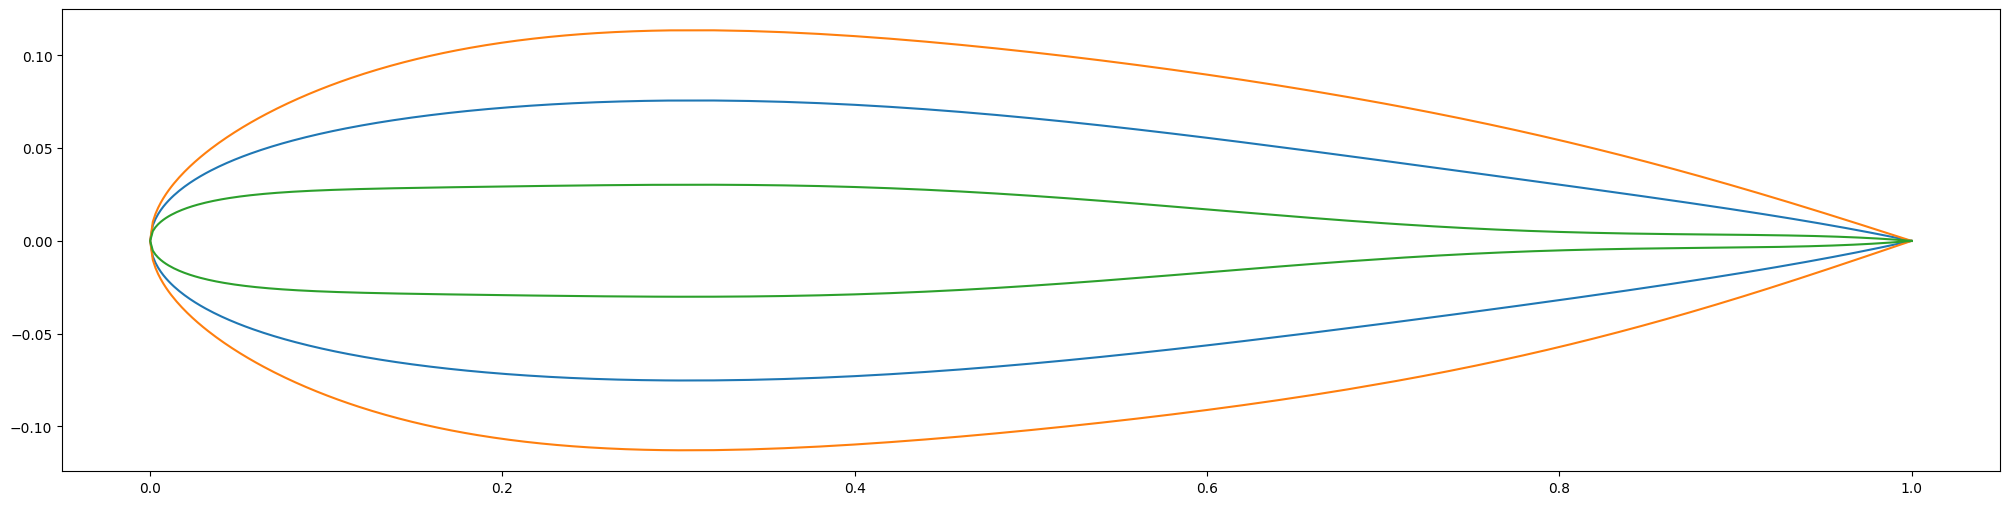

In [20]:
plt.figure(figsize=(25,6))
j=40
t=150
plot_combi(100,100,100,100,100,100,100,100)
plot_combi(t,t,t,t,t,t,t,t)
plot_combi(j,j,j,j,j,j,j,j)


<h3>->Impresión de varios perfiles

100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


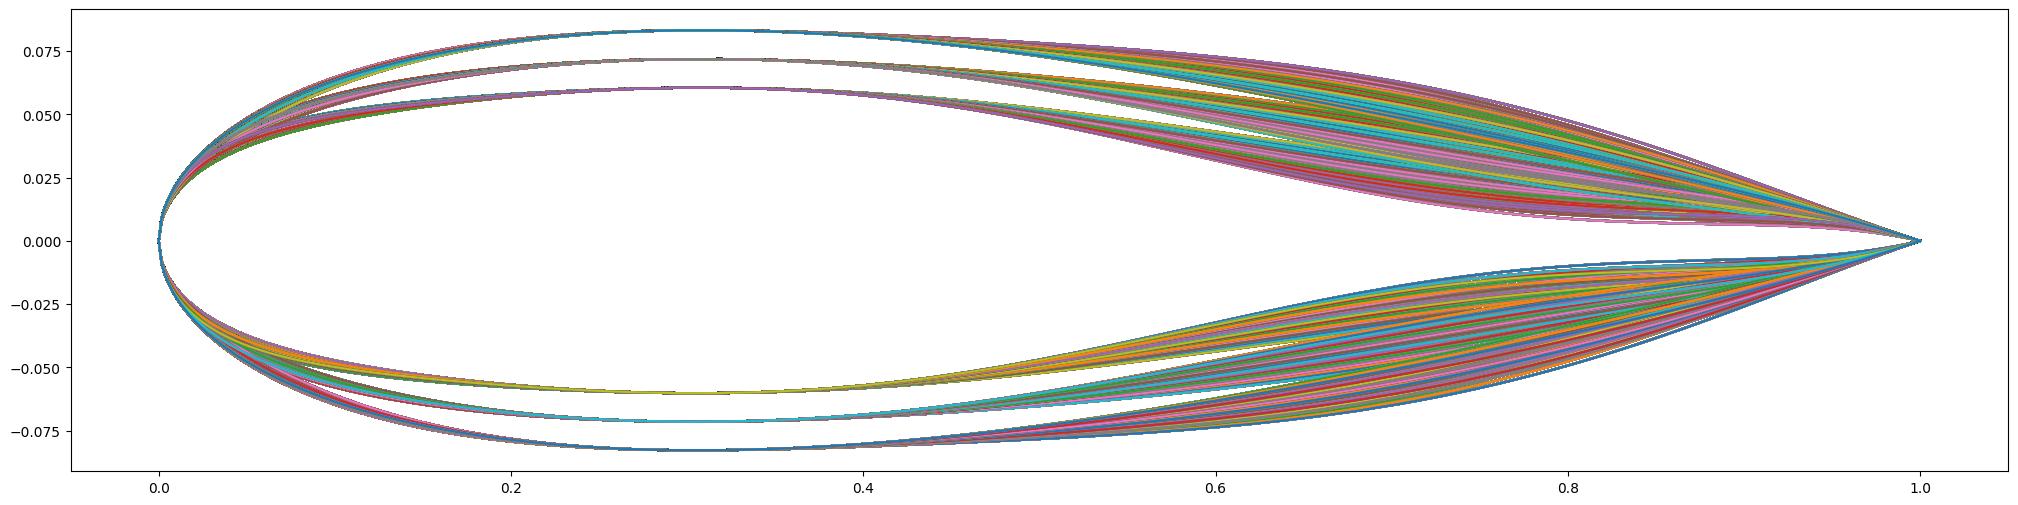

In [21]:
plt.figure(figsize=(25,6))
t=15
m=80
ma=120
for i in tqdm(range(m,ma,t)):
    for j in range(m,ma,t):
        for k in range(m,ma,t):
            for re in range(m,ma,t):
                for ra in range(m,ma,t):
                    for b in range(m,ma,t):
                        for ye in range(m,ma,t):
                            for yi in range(m,ma,t):
                                plot_combi(i,j,k,re,ra,b,ye,yi)

<h2>5. Creación de documentos para la simulación en Xfoil

Geometría del perfil

In [22]:
def create_coord_file(xx,yy,fname):
    test_result=""
    for i in range(len(xx)):
        x=xx[i]
        y=yy[i]
        test_result += f"{x:.6f}" + (" "*(4 if y >= 0 else 3)) + f"{y:.6f}\n"
    test_result
    file=open(fname + ".dat","w")
    file.write(test_result)
    file.close()

Datos de simulación que ingresan a Xfoil y creación de archivo "resultados"

In [23]:
def run_simulation(i,j,k,re,ra,b,ye,yi,fname=None):
    xx,yy=get_coord_combi(i,j,k,re,ra,b,ye,yi)
    if fname is None:
        fname=f"0015/barrido/sim_{i}_{j}_{k}_{re}_{ra}_{b}_{ye}_{yi}"
    create_coord_file(xx,yy,fname)
    strname = str(fname) + '.txt'
    airfoil_name = fname
    alpha_i = 0
    alpha_f = 20
    alpha_step = 1
    Re = 74290
    n_iter = 100

    # %% XFOIL input file writer 

    if os.path.exists(strname):
        os.remove(strname)

    input_file = open(fname+".in", 'w')
    input_file.write("LOAD {0}.dat\n".format(airfoil_name))
    input_file.write(airfoil_name + '\n')
    input_file.write("MDES\n")
    input_file.write("FILT\n") 
    input_file.write("EXEC\n")
    input_file.write("\n")
    input_file.write("PANE\n")
    input_file.write("OPER\n")
    input_file.write("ITER {0}\n".format(n_iter))
    input_file.write("Visc {0}\n".format(Re))
    input_file.write("PACC\n")
    input_file.write(strname+"\n\n ")
    input_file.write("ASeq {0} {1} {2}\n".format(alpha_i, alpha_f, alpha_step))
    input_file.write("\n\n")
    input_file.write("quit\n")
    input_file.close()

    process = subprocess.Popen("xfoil.exe < " + fname + ".in", shell=True)

    try:
        process.wait(timeout=10)
    except subprocess.TimeoutExpired:
        for child in psutil.Process(process.pid).children(recursive=True):
            child.kill()
        process.kill()

        print("killed " + fname + " after timeout")

Se indica a Xfoil que corra los datos anteriores

In [24]:
'''t=20
m=80
ma=120
for i in tqdm(range(m,ma,t)):
    for j in range(m,ma,t):
        for k in range(m,ma,t):
            for re in range(m,ma,t):
                for ra in range(m,ma,t):
                    for b in range(m,ma,t):
                        for ye in range(m,ma,t):
                            for yi in range(m,ma,t):
                                run_simulation(i,j,k,re,ra,b,ye,yi)'''

't=20\nm=80\nma=120\nfor i in tqdm(range(m,ma,t)):\n    for j in range(m,ma,t):\n        for k in range(m,ma,t):\n            for re in range(m,ma,t):\n                for ra in range(m,ma,t):\n                    for b in range(m,ma,t):\n                        for ye in range(m,ma,t):\n                            for yi in range(m,ma,t):\n                                run_simulation(i,j,k,re,ra,b,ye,yi)'

<h2>6. Lectura de archivos para comparar el mejor


Lectura de archivo

In [25]:
def get_params_from_fname(fname):
    params = regex.search(r'sim_(\d+(?:\.\d+)?)_(\d+(?:\.\d+)?)_(\d+(?:\.\d+)?)_(\d+(?:\.\d+)?)_(\d+(?:\.\d+)?)_(\d+(?:\.\d+)?)_(\d+(?:\.\d+)?)_(\d+(?:\.\d+)?)\.txt', fname)
    return [params.group(i) for i in range(1, 9)]

Ingreso al documento para separar las columnas de los archivos 

In [26]:
def filter_empty(values):
  return list(filter(lambda line: False if line == "" else True, values))

def get_values(line):
  values = regex.split(r'\s+', line)
  values = filter_empty(values)
  return list(map(float, values))

def get_table(file):
  match_ = regex.search(r'((?:-{2,} *)+)', file)
  match_.groups(1)
  
  table = file[match_.end(1): len(file)]
  lines = table.split("\n")
  lines = filter_empty(lines)

  values = list(map(get_values, lines))
  return values

Calculo de la eficiencia dentro de los archivos 

In [27]:
def get_value(table):
    cl_values=list(map(lambda line: line[1]/line[2], table))
    prom=np.mean(cl_values) if len(cl_values) > 0  else -math.inf
    return prom
    #return cl_values[6]

Por medio de "Queue" biblioteca de python se crea una lista de prioridad que permite ver el rango entre los parametros 

In [28]:
X=PriorityQueue()
queue_index=PriorityQueue()


In [29]:
def key_from_params(params):
  n = len(params)

  t = 0

  for i in range(n):
    v = int(params[n - i - 1])
    m = 10**(i*3)
    t += m*v

  return t

In [30]:
for name in glob.glob('./0015/barrido/sim*.txt'):
    f = open(name, "r")
    content=f.read()
    params=get_params_from_fname(name)
    values = get_table(content)
    result=get_value(values) 
    if not math.isfinite(result):
        continue
    X.put((-result,params))#El orden da negativo pero no es el valor real, son positivos 

    order=key_from_params(params)
    queue_index.put((order,result))#ordenar de acuerdo a la combinacion

    f.close()    

<h1> 7. Lista ordenada de mejores eficiencias a peores

In [31]:
n = 0
top=[]
while not X.empty():
    priority,params = X.get()
    priority*=-1
    top.append((priority,params))
    n += 1
display(top)

[(26.902321184653637, ['80', '80', '80', '101', '87', '80', '108', '80']),
 (26.193996701214687, ['80', '80', '80', '87', '101', '115', '101', '94']),
 (26.109499588727207, ['80', '80', '80', '101', '80', '115', '115', '94']),
 (25.938538798253667, ['80', '80', '80', '80', '80', '108', '108', '87']),
 (25.920781045484386, ['80', '80', '80', '94', '101', '108', '108', '94']),
 (25.907403677707016, ['80', '80', '80', '101', '108', '115', '108', '94']),
 (25.900188437448932, ['80', '80', '80', '80', '80', '94', '108', '94']),
 (25.89056926699531, ['100', '80', '100', '80', '100', '80', '100', '100']),
 (25.7196592597677, ['80', '80', '80', '101', '108', '94', '108', '101']),
 (25.705342267791774, ['80', '80', '80', '94', '108', '108', '108', '87']),
 (25.694874488181508, ['80', '80', '80', '87', '101', '94', '101', '80']),
 (25.655661370201862, ['80', '80', '80', '108', '80', '115', '101', '87']),
 (25.648079790653746, ['80', '80', '80', '87', '115', '94', '108', '87']),
 (25.604516204124

->Orden de archivos 


In [32]:
n2=0
top_order=[]
while not queue_index.empty():
    _,params = queue_index.get()
    top_order.append((n2,params))
    n2 += 1
display(top_order)

[(0, 14.201245493547159),
 (1, 13.332574290767157),
 (2, 13.44296317058992),
 (3, 12.577740195547392),
 (4, 12.510007613913201),
 (5, 11.829283813058748),
 (6, 11.76619939236451),
 (7, 15.412245041708909),
 (8, 16.335442901275098),
 (9, 15.08226947246185),
 (10, 14.440353479595213),
 (11, 13.944138701577328),
 (12, 14.187711390665882),
 (13, 17.738022186634932),
 (14, 17.113458751245712),
 (15, 18.320235173963567),
 (16, 16.36169719596831),
 (17, 16.332299706454204),
 (18, 15.757743536835799),
 (19, 19.396823691670058),
 (20, 18.472944936411174),
 (21, 25.283398590613327),
 (22, 18.666987309340698),
 (23, 19.043797574125417),
 (24, 18.589445223325637),
 (25, 18.211469934064386),
 (26, 17.546951285171694),
 (27, 20.187100100230907),
 (28, 21.915722658268226),
 (29, 19.640735038580015),
 (30, 19.309547348135432),
 (31, 19.18608160554764),
 (32, 18.67257346784043),
 (33, 25.03453183648119),
 (34, 21.199839457747334),
 (35, 19.83483400042482),
 (36, 20.424771020188615),
 (37, 21.1139419479

<h2> Graficas que muestran el comportamiento de las diferentes combinaciones

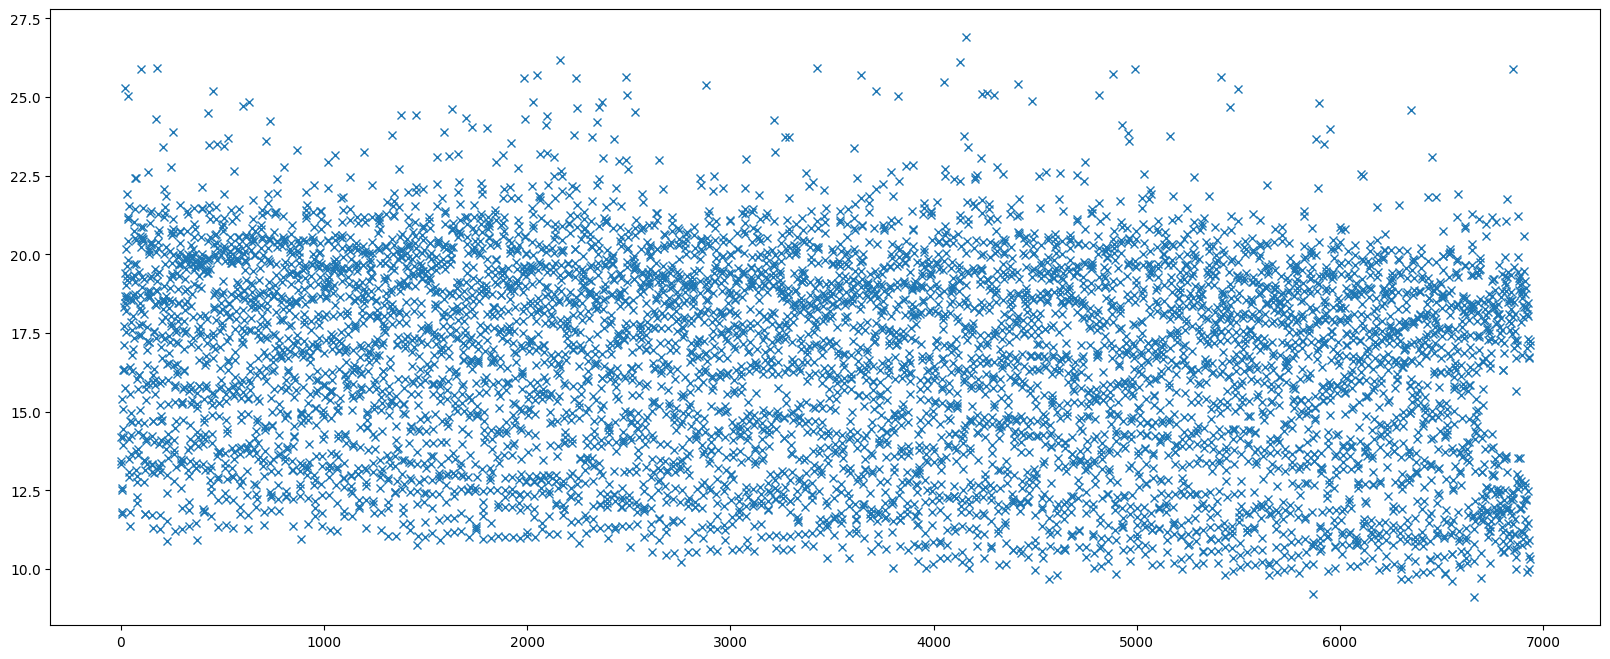

In [33]:
x = list(map(lambda x: x[0], top_order))
y = list(map(lambda x: x[1], top_order))
plt.figure(figsize=(20,8))
plt.plot(x,y,"x")



#Grafica por partes

In [34]:
uid=int(0)
def evalue_sim(x):
    global uid
    i,j,k,re,ra,yi,ye,b=x
    name=f"results_opt/_sim_{uid}"
    name2=name
    run_simulation(i,j,k,re,ra,yi,ye,b,fname=name) #asignar a la fuerza un nombre 
    name+=".txt"
    f = open(name, "r")
    content=f.read()
    values = get_table(content)
    result=-get_value(values)
    f.close()
    os.remove(name2+".dat")
    try:
        os.remove(name2+".in")
    except PermissionError:
        print("PermissionError")
    uid+=1
    return result

In [64]:
X=[]
nmax=50000
n=0
for item in tqdm(os.scandir('./results_opt')):
    name="./results_opt/"+item.name

    n+=1
    if n>nmax:
        break
    f = open(name, "r")
    content=f.read()
    values = get_table(content)
    result=get_value(values) 
    if not math.isfinite(result):
        continue
    X.append(result)
    f.close()    
plt.plot(X)

59it [00:00, 3804.27it/s]


AttributeError: 'NoneType' object has no attribute 'groups'

In [36]:
history=[]
def evalue_sim_save(v_var):
    results_opt=-evalue_sim(v_var)
    history.append(results_opt)
    return results_opt

def local_min(x,y,_):
    history.append(y)
    

In [37]:
m=80
ma=120
rangei=(m,ma)
rangej=(m,ma)
rangek=(m,ma)
rangere=(m,ma)
rangera=(m,ma)
rangeb=(m,ma)
rangeye=(m,ma)
rangeyi=(m,ma)
maxim = dual_annealing(evalue_sim, bounds=(rangei, rangej, rangek,rangere,rangera,rangeb,rangeye,rangeyi), callback=local_min, maxiter=1000)
maxim

killed results_opt/_sim_704 after timeout
PermissionError
killed results_opt/_sim_1005 after timeout
PermissionError
killed results_opt/_sim_1008 after timeout
PermissionError
killed results_opt/_sim_1009 after timeout
PermissionError
killed results_opt/_sim_1010 after timeout
PermissionError
killed results_opt/_sim_1011 after timeout
PermissionError
killed results_opt/_sim_1012 after timeout
PermissionError
killed results_opt/_sim_1013 after timeout
PermissionError
killed results_opt/_sim_1014 after timeout
PermissionError
killed results_opt/_sim_1015 after timeout
PermissionError
killed results_opt/_sim_1016 after timeout
PermissionError
killed results_opt/_sim_1896 after timeout
PermissionError
killed results_opt/_sim_2233 after timeout
PermissionError
killed results_opt/_sim_2695 after timeout
PermissionError
killed results_opt/_sim_3656 after timeout
PermissionError
killed results_opt/_sim_4340 after timeout
PermissionError
killed results_opt/_sim_5318 after timeout
PermissionErro

 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: -30.05562708434143
       x: [ 1.073e+02  1.138e+02  8.383e+01  9.514e+01  8.070e+01
            1.012e+02  1.190e+02  9.178e+01]
     nit: 1000
    nfev: 16136
    njev: 15
    nhev: 0

In [57]:
history2=list(map(lambda x:-x,filter(lambda x:math.isfinite(x),history)))
print(history2)

[18.587511869311115, 20.8376636932085, 21.22938592893242, 23.41351430478243, 24.35606332858299, 25.523887235821302, 26.46354809260995, 26.632894799370547, 28.142506349538863, 28.26083049348389, 28.997938067830752, 29.02176694353188, 29.022196849045383, 29.029582358257752, 29.047688004078136, 29.642733623829493, 29.655649462851027, 30.05562708434143]


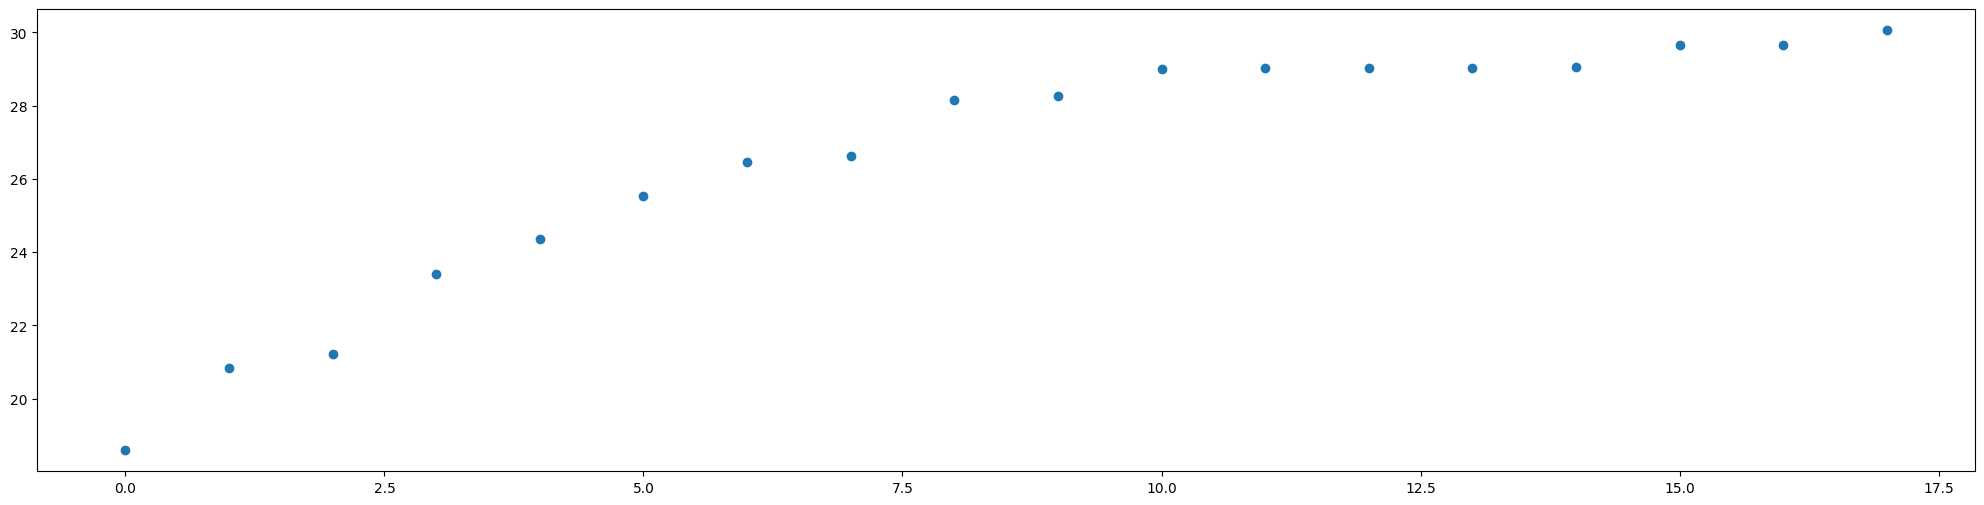

In [58]:
plt.figure(figsize=(25,6))
plt.scatter(range(0,len(history2)),history2)

In [66]:
data=pd.DataFrame({"x": history2})
'''s=float(data.std())
u=float(data.mean())
data["distance"]=np.abs(data["x"]-u)
data["z"]=data["distance"]/s
data[data["z"]<=3]
data.describe()''' #se intento sacar valores atipicos pero no quito nada

median=float(data.quantile(0.1))
data=data[data["x"]>=median]
data

C:\Users\Juan\AppData\Local\Temp\ipykernel_15860\2000461163.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  median=float(data.quantile(0.1))


,x
2,21.229386
3,23.413514
4,24.356063
5,25.523887
6,26.463548
7,26.632895
8,28.142506
9,28.260830
10,28.997938
11,29.021767


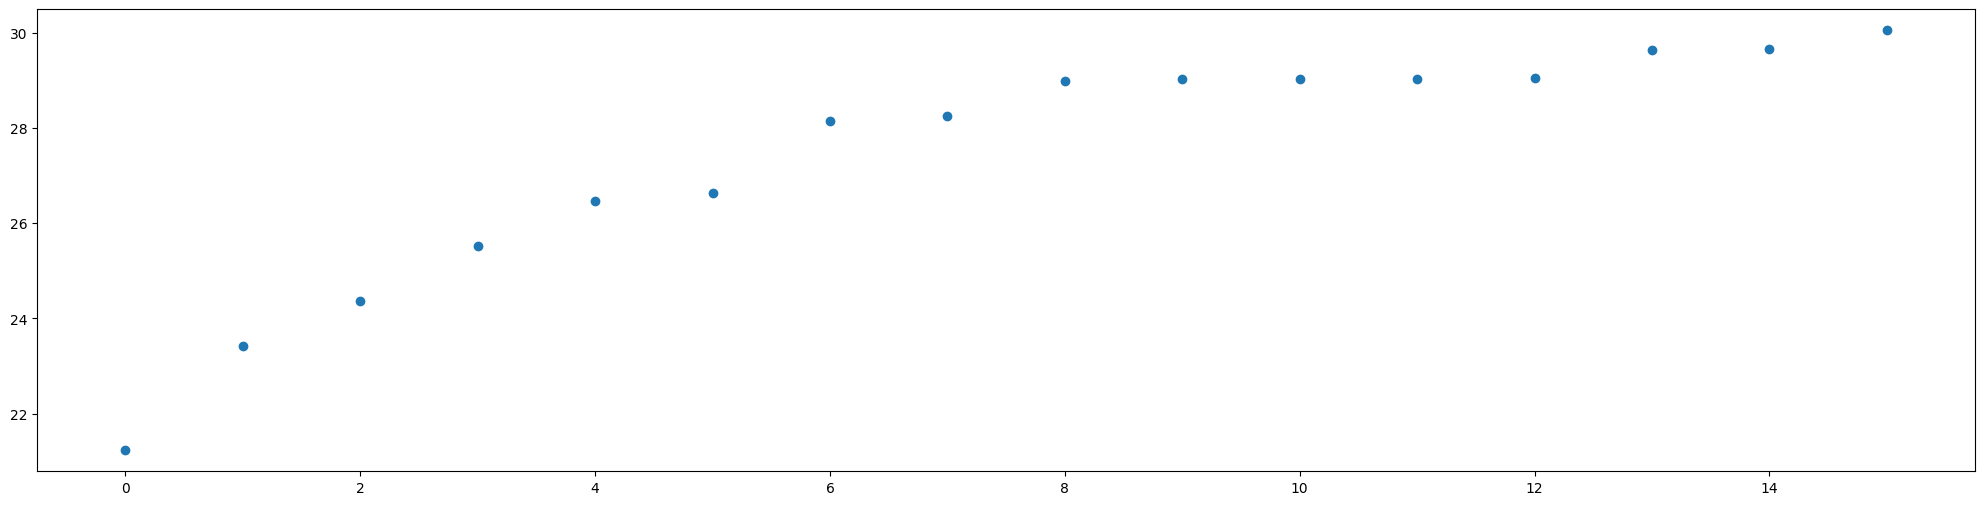

In [67]:
datazoom=data#[(data.index>9000)&(data.index<11000)]
plt.figure(figsize=(25,6))
plt.scatter(range(len(datazoom)),datazoom["x"])
#plt.plot(range(len(datazoom)),datazoom["x"], c="red")

In [68]:
datamax=[]
xmax=-float("inf")
for x in history2:
    if x>xmax:
        xmax=x
    datamax.append(xmax)

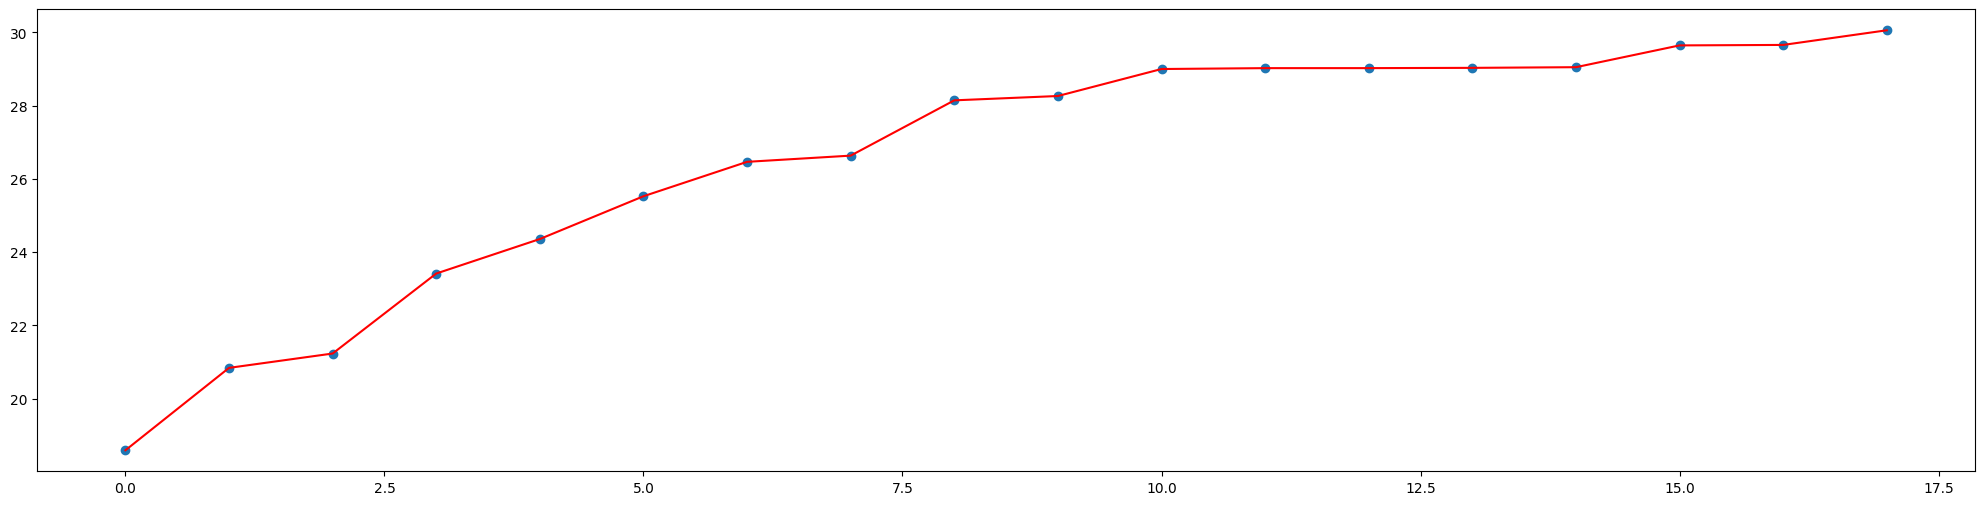

In [69]:
plt.figure(figsize=(25,6))
plt.scatter(range(0,len(history2)),history2)
plt.plot(datamax,c="red")

<h1> Evaluación de iteraciones Xfoil

In [44]:
def run2_simulation(i,j,k,fname=None):
    xx,yy=get_coord_combi(i,j,k)
    if fname is None:
        fname=f"Evalue_it/sim_{w}_{i}_{j}_{k}"
    create_coord_file(xx,yy,fname)
    strname = str(fname) + '.txt'
    airfoil_name = fname
    alpha_i = 1
    alpha_f = 10
    alpha_step = 1
    Re = 10000
    n_iter = w

    # %% XFOIL input file writer 

    if os.path.exists(strname):
        os.remove(strname)

    input_file = open(fname+".in", 'w')
    input_file.write("LOAD {0}.dat\n".format(airfoil_name))
    input_file.write(airfoil_name + '\n')  
    input_file.write("PANE\n")
    input_file.write("OPER\n")
    input_file.write("Visc {0}\n".format(Re))
    input_file.write("PACC\n")
    input_file.write(strname+"\n\n ")
    input_file.write("ITER {0}\n".format(n_iter))
    input_file.write("ASeq {0} {1} {2}\n".format(alpha_i, alpha_f, alpha_step))
    input_file.write("\n\n")
    input_file.write("quit\n")
    input_file.close()

    process = subprocess.Popen("xfoil.exe < " + fname + ".in", shell=True)

    try:
        process.wait(timeout=60)
    except subprocess.TimeoutExpired:
        for child in psutil.Process(process.pid).children(recursive=True):
            child.kill()
        process.kill()

        print("killed " + fname + " after timeout")
    

In [45]:
#for w in range(1,100,10):
#    run2_simulation(100,100,100)

#for w in range(100,1000,100):
#    run2_simulation(100,100,10)

In [46]:
def get_params_from_fname2(fname):
    params = regex.search(r'sim_(\d+(?:\.\d+)?)_(\d+(?:\.\d+)?)_(\d+(?:\.\d+)?)_(\d+(?:\.\d+)?)\.txt', fname)
    return [params.group(i) for i in range(1, 4)]

In [47]:
def filter_empty2(values):
  return list(filter(lambda line: False if line == "" else True, values))

def get_values2(line):
  values = regex.split(r'\s+', line)
  values = filter_empty2(values)
  return list(map(float, values))

def get_table2(file):
  match_ = regex.search(r'((?:-{2,} *)+)', file)
  match_.groups(1)
  
  table = file[match_.end(1): len(file)]
  lines = table.split("\n")
  lines = filter_empty2(lines)

  values = list(map(get_values2, lines))
  return values

In [48]:
def get_value2(table):
    cl_values=list(map(lambda line: line[1], table))
    prom=np.mean(cl_values)  
    return prom
    #return cl_values[6]

In [49]:
X=PriorityQueue()

In [50]:
for name in glob.glob('./Evalue_it/sim_*.txt'):
    f = open(name, "r")
    content=f.read()
    params=get_params_from_fname2(name)
    values = get_table2(content)
    result=get_value2(values)
    X.put((-result,params))#El orden da negativo pero no es el valor real, son positivos 
    f.close()

In [51]:
n = 0
top=[]
while not X.empty():
    priority,params = X.get()
    priority*=-1
    top.append((priority,params))
    n += 1
display(top)

[]

In [52]:
w = [None] * 19  # Assuming you want a list of size 20 for this example
i = 0  # Initialize the index variable
for e in range(1, 100, 10):
    w[i] = e
    i += 1  # Increment the index variable

# Ensure that the index doesn't go out of bounds
for e in range(100, 1000, 100):
    if i < len(w):  # Check if the index is within the bounds of the list
        w[i] = e
        i += 1


In [53]:
CL=[]
I=[]
J=[]
K=[]
for cl, (i, j, k) in top:
    CL.append(cl)
    I.append(float(i))
    J.append(float(j))
    K.append(float(k))

In [54]:
CL=np.array(CL)
Cl_n=((abs(CL-0.3938))/0.3938)*100

In [55]:
len(Cl_n)

0

ValueError: x and y must have same first dimension, but have shapes (19,) and (0,)

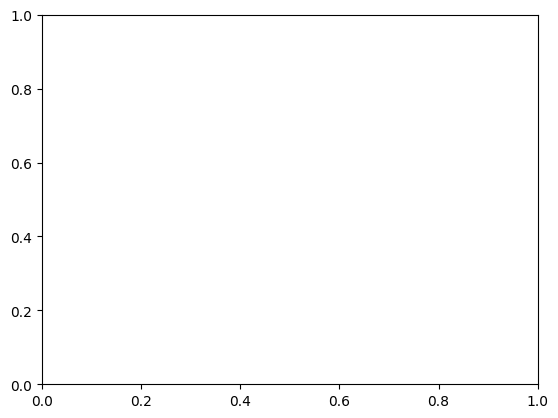

In [56]:
# Simulate data similar to the uploaded image
iterations = w
objective_values = CL

# Create a line plot
plt.plot(iterations, objective_values, color='black', linewidth=1)
plt.title("Iteraciones de Xfoil")
plt.xlabel("Número de iterationes")
plt.ylabel("CL")
plt.grid(True)
plt.xticks(range(0, max(iterations)+2, 100))  # Cambia el último valor (100) según tus necesidades
# Configura las etiquetas en el eje Y manualmente
yticks = np.linspace(0.6, 1, 21)  # Crea 20 etiquetas entre 0.6 y 1
plt.yticks(yticks)
plt.show()